# Refactored_diffusion

In [1]:
from setup import *
from generators import * 
from utils import *
from denoising_unet import *

2024-02-22 15:06:18.138936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 15:06:18.260390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 15:06:18.260453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 15:06:18.278039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 15:06:18.323673: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import io
import cv2
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from keras import backend as K


In [3]:
batch_size = 32

In [4]:
high_path_2010_2019 = "data/wind_speed_italy_CERRA_2010-2019.npy"
high_path_2020 = "data/wind_speed_italy_CERRA_2020.npy"
high_path_2009 = "data/wind_speed_italy_CERRA_2009.npy"
high_path_balcans = "data/wind_speed_BALCANS_CERRA_2009.npy"


low_path_2010_2019 = "data/wind_speed_italy_ERA5_2010-2019.npy"
low_path_2020 = "data/wind_speed_italy_ERA5_2020.npy"
low_path_2009 = "data/wind_speed_italy_ERA5_2009.npy"
low_path_balcans = "data/wind_speed_BALCANS_ERA5_2009.npy"

In [5]:
train_generator = DataGeneratorMemmap(high_path_2010_2019,low_path_2010_2019, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2010_2019,sequential=False,batch_size = batch_size)

test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=False,batch_size = batch_size)

full_test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=True,batch_size = batch_size)

full_test_generator2009 = DataGeneratorMemmap(high_path_2009,low_path_2009, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,batch_size = batch_size)

full_test_generatorBALCANS = DataGeneratorMemmap(high_path_balcans,low_path_balcans, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,batch_size = batch_size)

In [6]:
# Experiment computing numerical results
def experiment(generator, n_iter=100):
    #raw = np.zeros((91,32,256,256))
    #define final mse array 
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sample = generator.__getitem__(i)
        # save a copy as ground truth 
        hist = np.copy(sample)
        #normalize sample before generation 
        sample = model.normalizer(sample)
        # compute generation with 15 diffusion steps 
        tmp = model.generate2(np.copy(sample),2)
        
        # Denormalize prediction and g.t.
        #hist = hist * maxRtesr
        #tmp = tmp * maxRtesr
        # compute the metric, sum on last two axis, mean on first. 
        mse = np.mean( ((hist[:,:,:,-1]-tmp[:,:,:,-1])**2))
        ssims[i] = batch_ssim(hist[:,:,:,-1],tmp[:,:,:,-1])
        
        psnrs[i] = batch_psnr(hist[:,:,:,-1],tmp[:,:,:,-1])
        
        mse_baseline = np.mean( ((hist[:,:,:,-1]-hist[:,:,:,-3])**2))
        ssims_baseline[i] = batch_ssim(hist[:,:,:,-1],hist[:,:,:,-3])
        psnrs_baseline[i] = batch_psnr(hist[:,:,:,-1],hist[:,:,:,-3])
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        #raw[i] = tmp[:,:,:,-1]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline#, raw

In [7]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, input_frames, output_frames, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, input_frames, output_frames, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)
        self.input_frames = input_frames
        self.output_frames = output_frames

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.image_loss_tracker, self.noise_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images[:,:,:,-self.output_frames:] - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images
  
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        past = initial_noise[:,:,:,:-self.output_frames]
        #future = initial_noise[-1]
        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            #print("noisy im ",noisy_images.shape)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode
            
            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_frames = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
            #concatenate predicted single frame with past known frames 
            next_noisy_images = tf.concat([past, next_noisy_frames], axis = -1)

        return pred_images

    def generate2(self, images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(images.shape[0], images.shape[1], images.shape[2], self.output_frames))
        images[:,:,:,-self.output_frames:] = initial_noise
        generated_images = self.reverse_diffusion(images, diffusion_steps)
        generated_images = self.denormalize(tf.concat([images[:,:,:,:-self.output_frames],generated_images],axis=-1))
        return generated_images
        
    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        
        #normalize only real images
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, self.output_frames))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        target = images[:,:,:,-self.output_frames:]
        noisy_images = signal_rates * target + noise_rates * noises
        
        #concat the images with added noises with the originals 
        noise_two =  tf.concat([images[:,:,:,:-self.output_frames],noisy_images],axis=-1)
        #print(noise_two.shape)

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noise_two, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(target, pred_images)  # only used as metric

        # Training on noise_loss (default)
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        
        # Training on image_loss
        #gradients = tape.gradient(image_loss, self.network.trainable_weights)
        
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
            
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, self.output_frames))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        target = images[:,:,:,-self.output_frames:]
        noisy_images = signal_rates * target + noise_rates * noises
        
        noise_two =  tf.concat([images[:,:,:,:-self.output_frames],noisy_images],axis=-1)

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noise_two, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(target, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def plotter(self,epoch, logs):
        
        exp, baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment(test_generator,20)
        predmse = np.mean(exp)
        basemse = np.mean(baseline)
        
        predpsnr = np.mean(psnrs)
        predbasepsnr = np.mean(psnrs_baseline)
        
        predssim = np.mean(ssims)
        predbasessim = np.mean(ssims_baseline)
        
        print("mse pred: ",predmse)
        print("mse base: ",basemse)
        
        print("psnr pred: ",predpsnr)
        print("psnr base: ",predbasepsnr)
        
        print("ssim pred: ",predssim)
        print("ssim base: ",predbasessim)

        #UNCOMMMENT IF NEEDED 
        #sample = val_generator.__getitem__(1)
        #sample = test_generator.__getitem__(1)
        #hist = np.copy(sample)
        #sample = model.normalizer(sample)

        #tmp = model.generate2(np.copy(sample),15)
        #plt.figure(figsize=(10,10))
        #for i in range(tmp.shape[-1]):
        #        plt.subplot(1, tmp.shape[-1], i + 1)
        #        plt.imshow(tmp[0,:,:,i])
        #        plt.axis("off")
        #
        #plt.tight_layout()
        #plt.show()
        #plt.close()

### Training

In [8]:
model = DiffusionModel(image_size, 4, 1, widths, block_depth)

optimizer=keras.optimizers.experimental.AdamW
model.compile(
    optimizer=optimizer(
        learning_rate=1e-5, weight_decay=1e-6
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss


2024-02-22 15:06:21.207050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 15:06:21.283073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 15:06:21.283242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
model.normalizer.adapt(train_generator.__getitem__(1))
model.normalizer.mean = np.load("correct_diffusion_mean.npy").astype(np.float32)
model.normalizer.variance = np.load("correct_diffusion_variance.npy").astype(np.float32)

2024-02-22 15:06:23.610877: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [10]:
model.network.summary()

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 1, 1)]            0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 256, 256, 5)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 1, 64)             0         ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         384       ['input_1[0][0]']             
                                                                                      

In [11]:
# Load weights
#e = 12 # Saved epoch
model.network.load_weights("weights/220WindspeedDiffusion")
model.ema_network.load_weights("weights/220WindspeedDiffusion_ema")

In [12]:
 def saver(epoch, logs):
        if(epoch % 10 == 0):
            print("saved")
            model.network.save_weights("correct_weights/"+str(epoch)+"WindspeedDiffusion")
            model.ema_network.save_weights("correct_weights/"+str(epoch)+"WindspeedDiffusion_ema")
                

In [13]:
def file_plotter(self,epoch, logs):

    exp, baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment(test_generator,20)
    predmse = np.mean(exp)
    basemse = np.mean(baseline)

    predpsnr = np.mean(psnrs)
    predbasepsnr = np.mean(psnrs_baseline)

    predssim = np.mean(ssims)
    predbasessim = np.mean(ssims_baseline)

    print("mse pred: ",predmse)
    print("mse base: ",basemse)

    print("psnr pred: ",predpsnr)
    print("psnr base: ",predbasepsnr)

    print("ssim pred: ",predssim)
    print("ssim base: ",predbasessim)

In [15]:
# Output callback is handy if training is done on a remote server where stdout is ueasily lost 
class OutputCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        with open(self.file_name, 'a') as f:
            exp, baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment(test_generator,20)
            predmse = np.mean(exp)
            basemse = np.mean(baseline)

            predpsnr = np.mean(psnrs)
            predbasepsnr = np.mean(psnrs_baseline)

            predssim = np.mean(ssims)
            predbasessim = np.mean(ssims_baseline)

            f.write(f'Epoch {epoch + 1}')
            
            f.write("mse pred: ",predmse)
            f.write("\nmse base: ",basemse)

            f.write("\npsnr pred: ",predpsnr)
            f.write("\npsnr base: ",predbasepsnr)

            f.write("\nssim pred: ",predssim)
            f.write("\nssim base: ",predbasessim)
            

# Create an instance of the callback
output_callback = OutputCallback('training_output.txt')

In [15]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='i_loss', factor=0.5,
                              patience=10, min_lr=0)

In [ ]:
history = model.fit(
    train_generator,
    initial_epoch = 0,
    epochs=200,
    steps_per_epoch=1000,
    #validation_data = val_generator,
    batch_size=batch_size,
    callbacks=[
        #reduce_lr,
        output_callback,
        #keras.callbacks.LambdaCallback(on_epoch_end=model.plotter),
        keras.callbacks.LambdaCallback(on_epoch_end=saver)
    ],
)

Epoch 122/221


In [ ]:
#model.network.save_weights("correct_weights/"+str(120)+"WindspeedDiffusion")
#model.ema_network.save_weights("correct_weights/"+str(120)+"WindspeedDiffusion_ema")


## Evaluation

In [16]:
np.random.seed(10)

In [17]:
sample = test_generator.__getitem__(10)
        # save a copy as ground truth 
hist = np.copy(sample)
        #normalize sample before generation 
sample = model.normalizer(sample)
        # compute generation with 15 diffusion steps 
tmp = model.generate2(np.copy(sample),2)

2024-02-22 15:07:49.753832: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-22 15:07:50.495528: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [23]:
def print_results2(a,b,printer):
    a = np.array(a)
    b = np.array(b)
    
    for i in range(6):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
        
        ax = axes[0]
        ax.imshow(a[i,:,:,-2], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("last low res")
        
        ax = axes[1]
        ax.imshow(b[i,:,:,-1], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("predicted")

        ax = axes[2]
        ax.imshow(a[i,:,:,-1], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("ground truth")       

        plt.tight_layout()
        #plt.savefig(printer + str(i) + ".png")
        plt.show()
        

In [21]:
#np.save("./visualization_recap_data/single_diffusion",tmp)

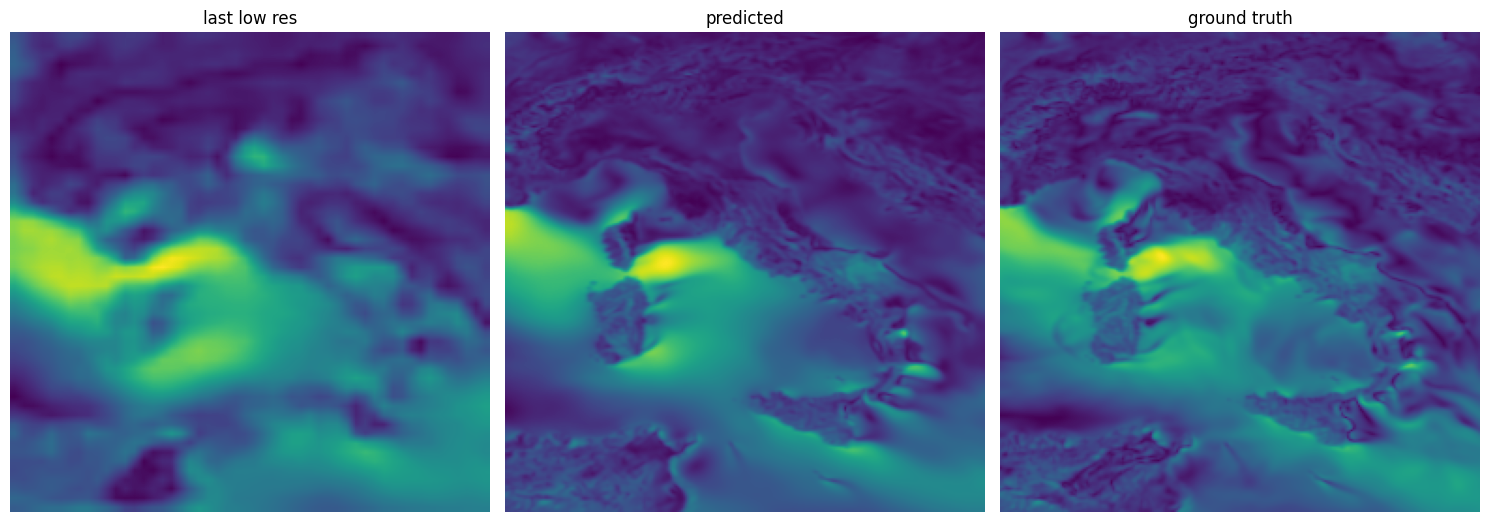

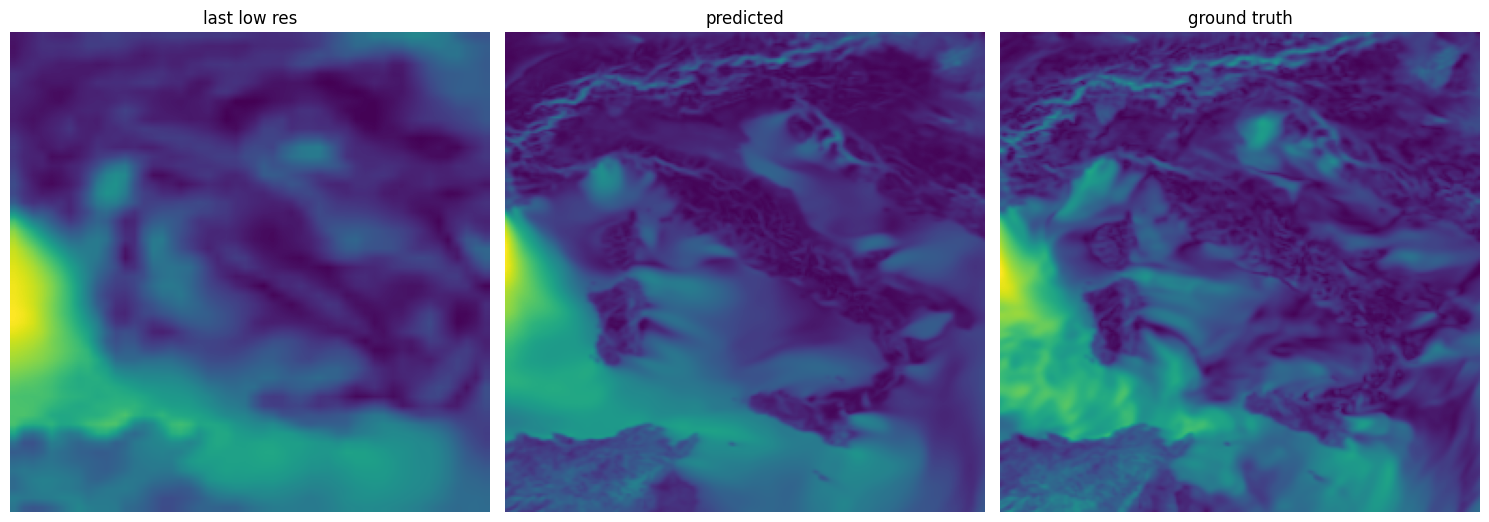

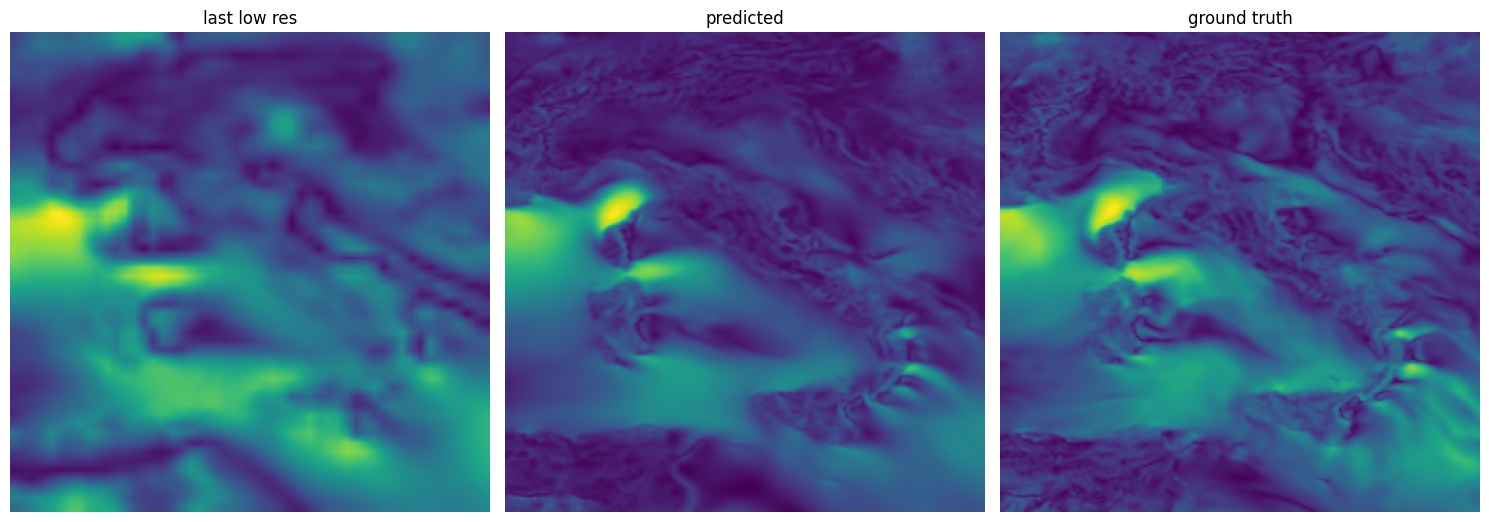

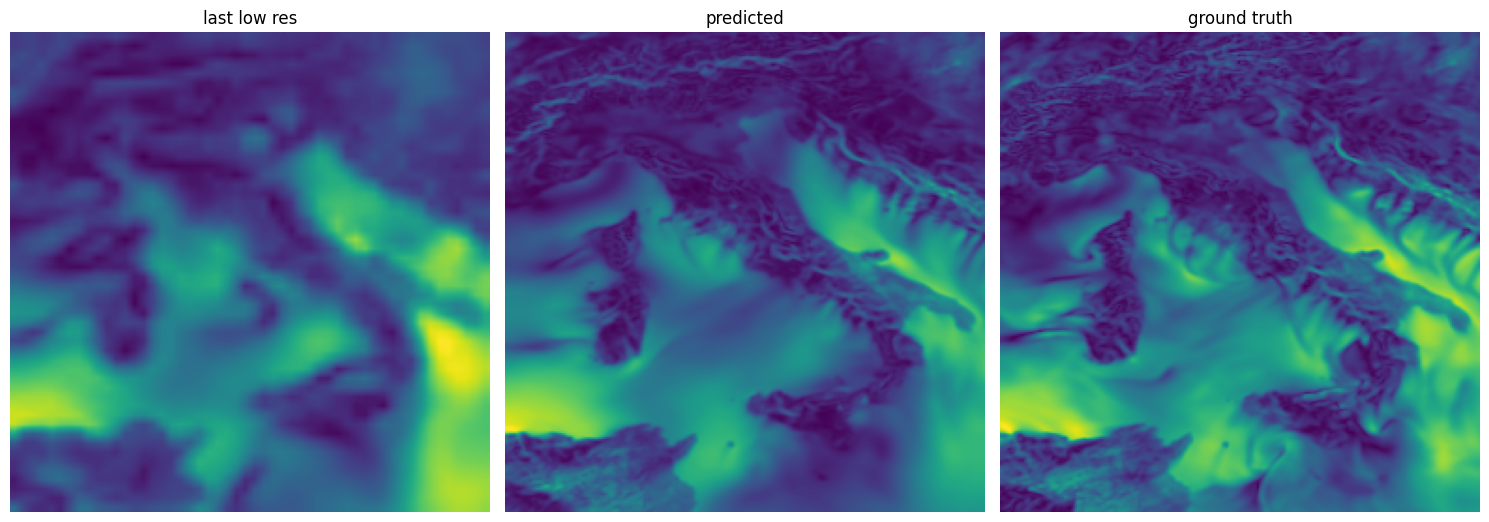

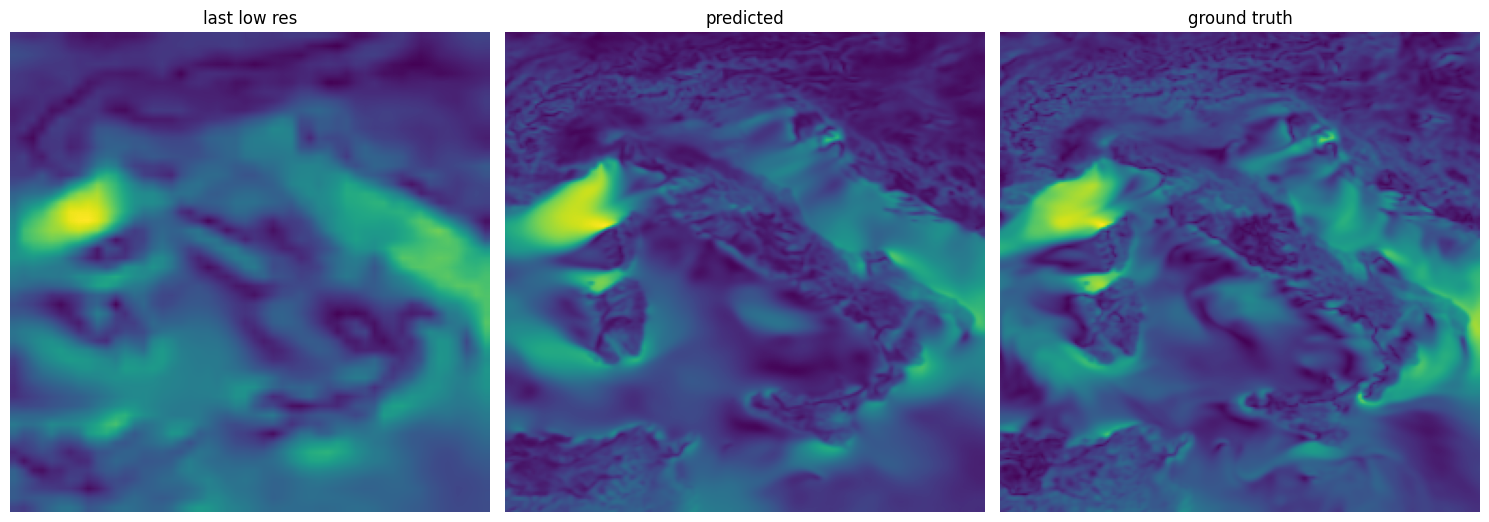

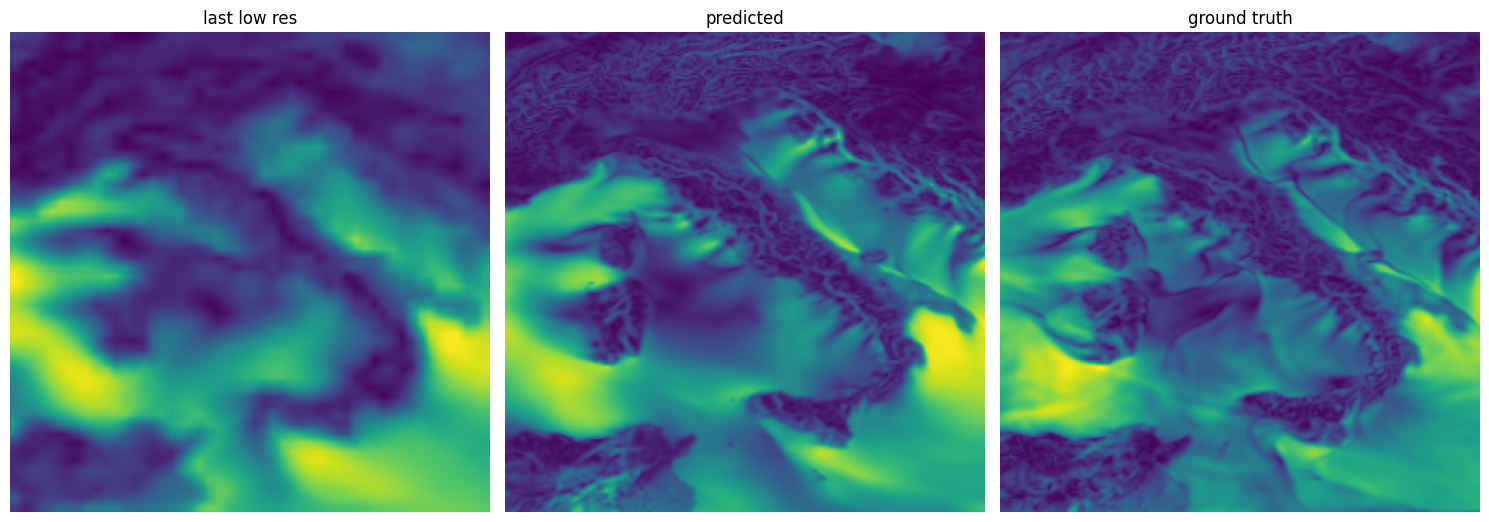

In [24]:
print_results2(hist,tmp,"diffusion")

In [16]:
import time
full_test_generator.counter_reset()
start_time = time.time()  # Capture the start time

full_test_generator2009.counter_reset()
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment(full_test_generator2009,91)

end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0


2024-01-09 16:13:30.523897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-09 16:13:30.597306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-01-09 16:13:31.013911: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 16:13:31.014207: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 16:13:31.014213: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-09 16:13:31.014544: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 16:13:31.014562: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTER

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


In [17]:
execution_time

285.76151180267334

In [19]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())
print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())
print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.8313321109735392   ssim baseline: 0.7120680397654988
psnrs: 29.849914241529603   psnrs_baseline: 26.678920946015747
mse: 0.0011374514631845138   mse baseline: 0.00238519486254904


In [20]:
np.save("numerical_results/diffusion2020_mses",mses)
#np.save("numerical_results/diffusion2020_mses_baseline",mses_baseline)

np.save("numerical_results/diffusion2020_psnrs",psnrs)
#np.save("numerical_results/diffusion2020_psnrs_baseline",psnrs_baseline)

np.save("numerical_results/diffusion2020_ssims",ssims)
#np.save("numerical_results/diffusion2020_ssims_baseline",ssims_baseline)

### Ensemble Diffusion

In [21]:
# Experiment with ensemble diffusion
def experiment2(generator, n_iter=10, ensamble_iter = 15, diffusion_steps = 5):
    #raw = np.zeros((91,32,256,256))
    #define final mse array 
    
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    
    for i in range(n_iter):
        #select a random batch in the test set 
        test = generator.__getitem__(i)
        
        print(i)
        
        # define an accumulator variable for ensamble 
        res = np.zeros([batch_size,ensamble_iter, 256,256, 5])
        # run ensamble iterations
        for j in range(ensamble_iter):

            #make a copy of the random batch 
            sample = np.copy(test)
            
            #normalize sample before generation
            sample = model.normalizer(sample)
            # compute generation with 15 steps 
            tmp = model.generate2(np.copy(sample),diffusion_steps)
            
            # denormalize prediction
            #tmp = tmp * maxRtesr
            
            #save prediction in accumulator 
            res[:,j] = tmp 
        
        # average all predictions in the ensamble
        average = np.mean(res,axis=1)
        #raw[i] = average[:,:,:,-1]
        # denormalize ground truth
        #hist = test * maxRtesr
        #compute mse between g.t. and average ensamble, sum on 2nd 3rd axis mean on 1st.
        mse = np.mean( ((test[:,:,:,-1]-average[:,:,:,-1])**2))
        ssims[i] = batch_ssim(test[:,:,:,-1],average[:,:,:,-1])
        psnrs[i] = batch_psnr(test[:,:,:,-1],average[:,:,:,-1])
        
        mse_baseline = np.mean( ((test[:,:,:,-1]-test[:,:,:,-3])**2))
        ssims_baseline[i] = batch_ssim(test[:,:,:,-1],test[:,:,:,-3])
        psnrs_baseline[i] = batch_psnr(test[:,:,:,-1],test[:,:,:,-3])
        
        mses_baseline[i] = mse_baseline
        mses[i] = mse 
        #sum all mses 
        print(mses)
        #print(mses / i)
            
    #average mses by number of iterations
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline

In [22]:
import time
full_test_generator.counter_reset()
start_time = time.time()  # Capture the start time

full_test_generator2009.counter_reset()
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment2(full_test_generator2009,91,15,5)

end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0
[0.00117525 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
1
[0.00117525 0.00133247 0.         0.         0.         0.
 0.         0.         0.         0.   

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
29
[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
38
[0.00089981 0.00112633 0.0008285  0.00061966 0.001256

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.00089293 0.00128942 0.0008981  0.00105534
 0.0009237  0.00085913 0.00058893 0.00068332 0.00092442 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
47
[0.00089981 0.00112633 0.0008285  0.00061966 

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.00089293 0.00128942 0.0008981  0.00105534
 0.0009237  0.00085913 0.00058893 0.00068332 0.00092442 0.00059835
 0.00079809 0.00074988 0.00049084 0.00072553 0.00048665 0.000903
 0.00098277 0.00061467 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
56
[0.00089981 0.00112633 0.000828

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.00089293 0.00128942 0.0008981  0.00105534
 0.0009237  0.00085913 0.00058893 0.00068332 0.00092442 0.00059835
 0.00079809 0.00074988 0.00049084 0.00072553 0.00048665 0.000903
 0.00098277 0.00061467 0.00077954 0.00068181 0.00062497 0.00068819
 0.00125559 0.00065675 0.00067772 0.00081334 0.00093179 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
65
[0.00089981 0.00112633 

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.00089293 0.00128942 0.0008981  0.00105534
 0.0009237  0.00085913 0.00058893 0.00068332 0.00092442 0.00059835
 0.00079809 0.00074988 0.00049084 0.00072553 0.00048665 0.000903
 0.00098277 0.00061467 0.00077954 0.00068181 0.00062497 0.00068819
 0.00125559 0.00065675 0.00067772 0.00081334 0.00093179 0.00084171
 0.00118535 0.00194515 0.00098282 0.00171415 0.0007233  0.00137943
 0.00090107 0.0006327  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
74
[0.0008

[0.00089981 0.00112633 0.0008285  0.00061966 0.00125661 0.0010644
 0.00106402 0.00100022 0.00218185 0.00082615 0.00173351 0.00086781
 0.0009509  0.0010621  0.00166472 0.00184144 0.00132987 0.00090557
 0.00090792 0.00059686 0.00122666 0.00148403 0.00107826 0.00112542
 0.00073387 0.0008139  0.00100936 0.00148377 0.00107188 0.00096765
 0.00136271 0.00093348 0.0011288  0.00176416 0.00172997 0.0009888
 0.00094205 0.00085295 0.00089293 0.00128942 0.0008981  0.00105534
 0.0009237  0.00085913 0.00058893 0.00068332 0.00092442 0.00059835
 0.00079809 0.00074988 0.00049084 0.00072553 0.00048665 0.000903
 0.00098277 0.00061467 0.00077954 0.00068181 0.00062497 0.00068819
 0.00125559 0.00065675 0.00067772 0.00081334 0.00093179 0.00084171
 0.00118535 0.00194515 0.00098282 0.00171415 0.0007233  0.00137943
 0.00090107 0.0006327  0.00106344 0.00094709 0.00058432 0.00073075
 0.00056738 0.00066046 0.00109375 0.00149326 0.00080515 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
83

In [23]:
execution_time

9281.879249334335

In [25]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.843918635095094   ssim baseline: 0.7080940925839915
psnrs: 30.100377228191626   psnrs_baseline: 26.36268835918632
mse: 0.001076355412673593   mse baseline: 0.0025665884435621526


In [26]:
np.save("./numerical_results/ensemble2020_mses",mses)
#np.save("numerical_results/ensamble2020_mses_baseline",mses_baseline)

np.save("./numerical_results/ensemble2020_psnrs",psnrs)
#np.save("numerical_results/ensamble2020_psnrs_baseline",psnrs_baseline)

np.save("./numerical_results/ensemble2020_ssims",ssims)
#np.save("numerical_results/ensamble2020_ssims_baseline",ssims_baseline)

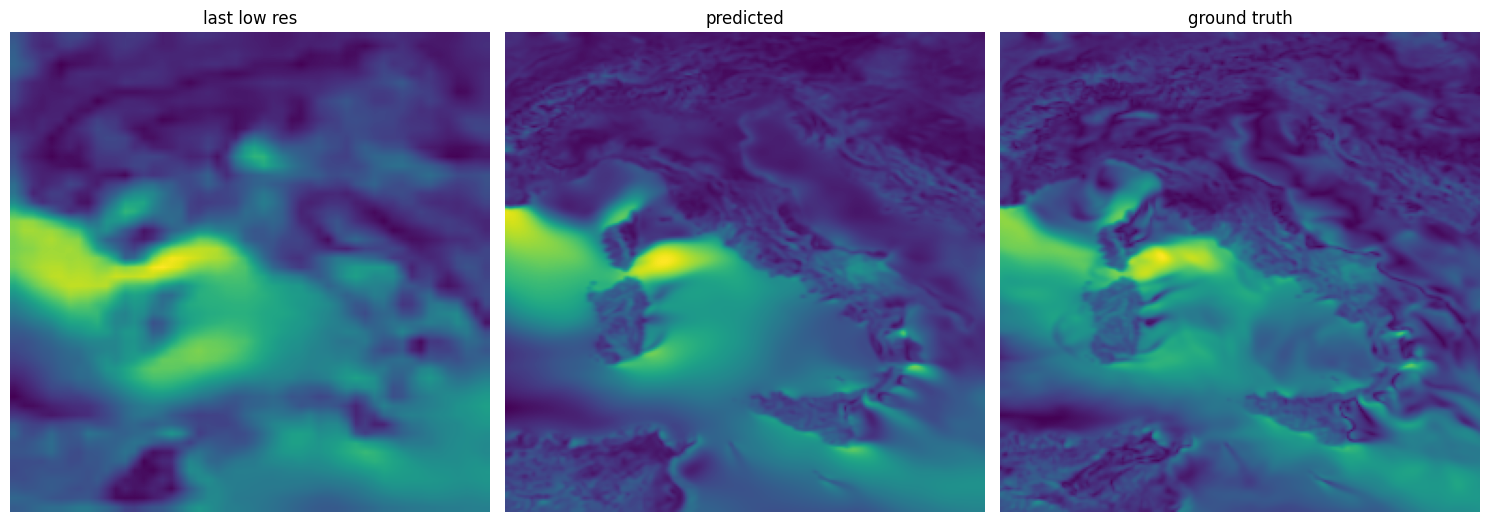

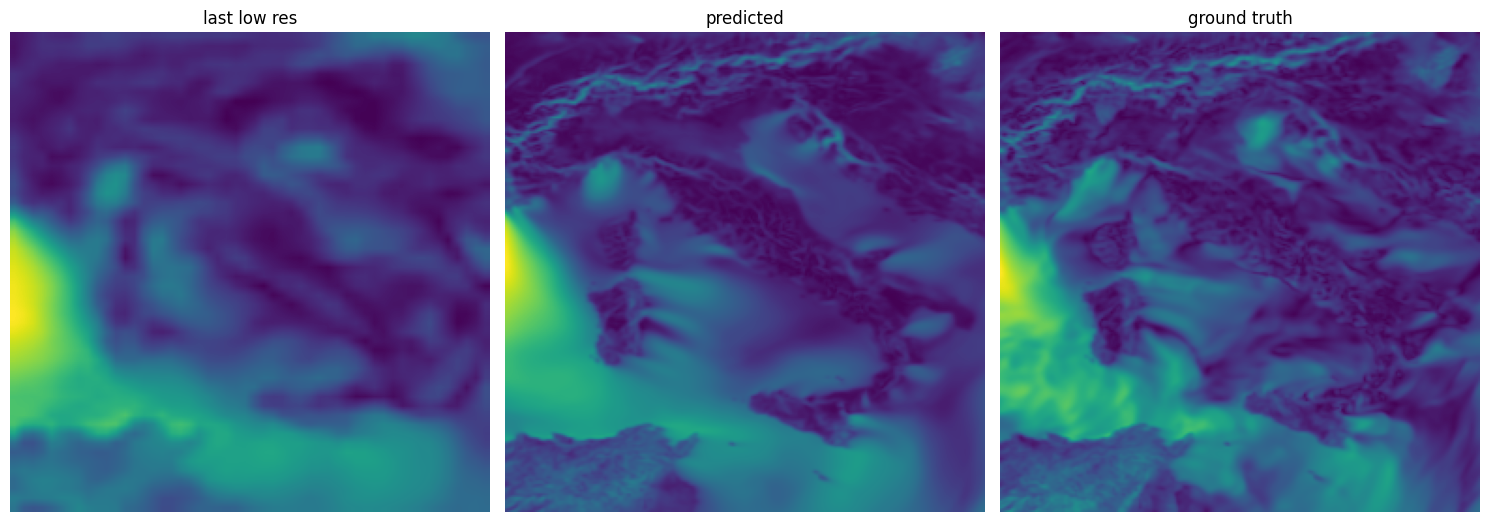

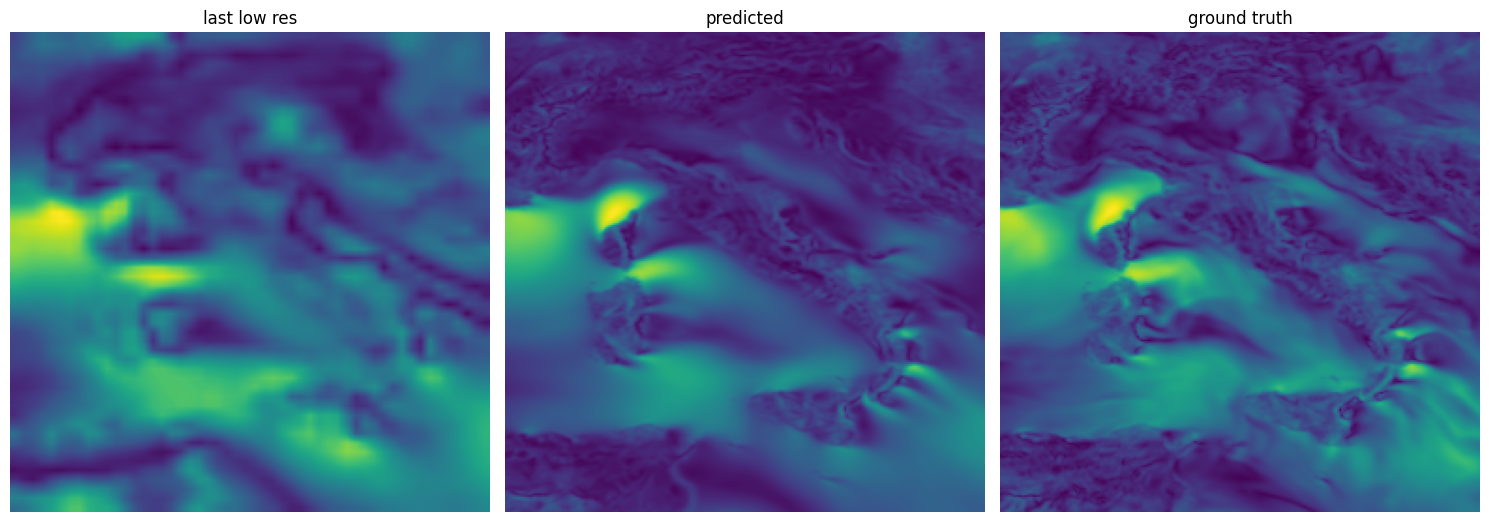

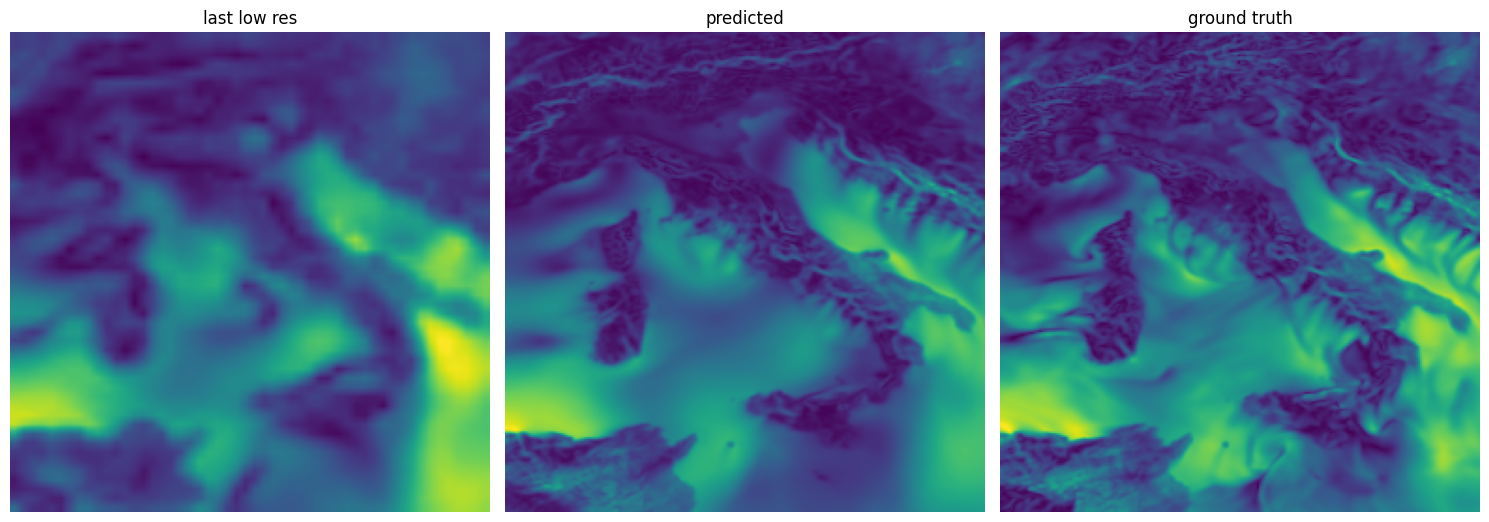

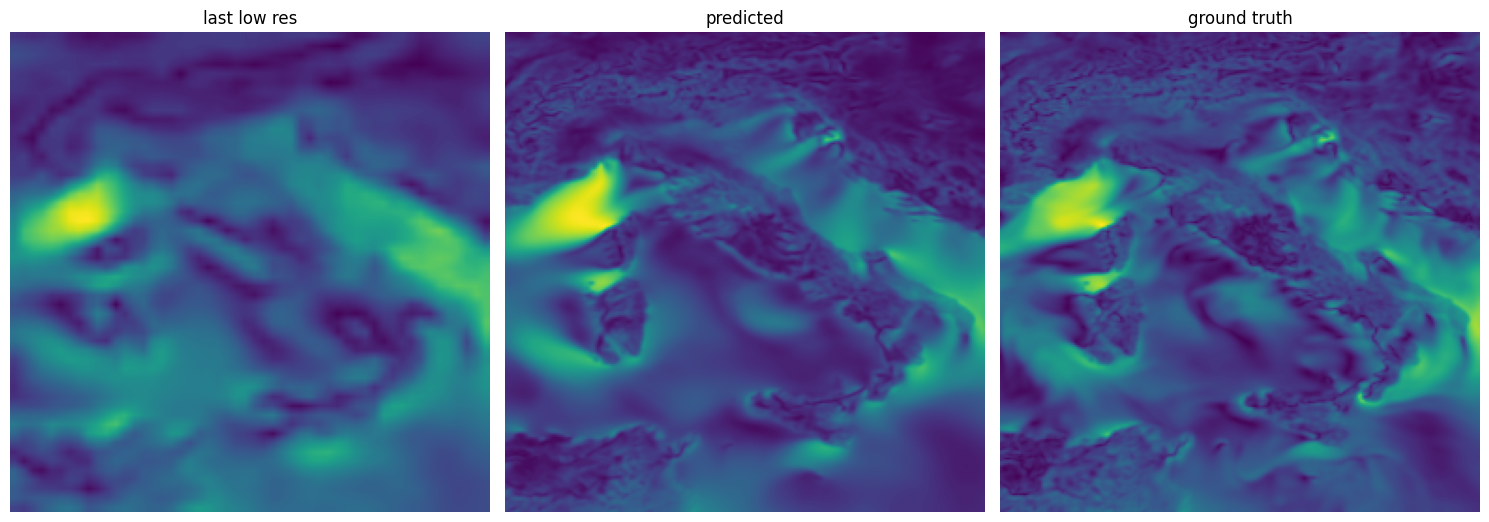

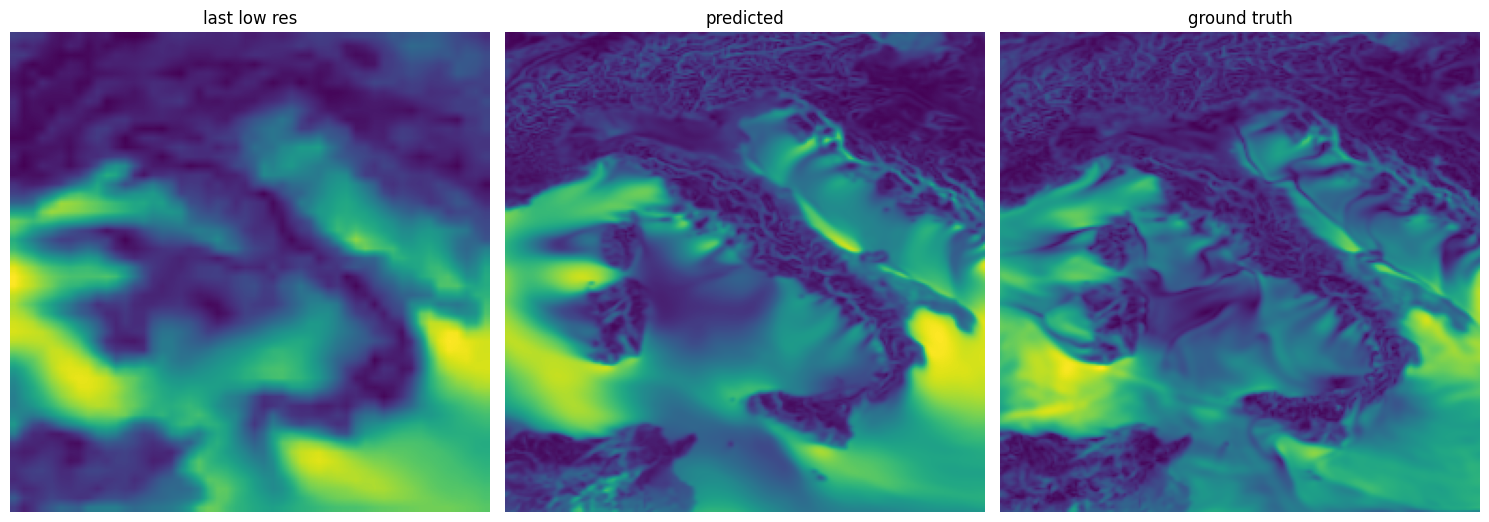

In [38]:
print_results2(hist,average,"ensamble")

## Extras

In [ ]:
def plot_sequence(data, start_idx=0, num_imgs=5):
    fig, axes = plt.subplots(1, num_imgs, figsize=(15, 3))
    
    for i in range(num_imgs):
        ax = axes[i]
        ax.imshow(data[start_idx + i], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title(f"Index {start_idx + i}")

    plt.tight_layout()
    plt.show()

# Plotting 5 contiguous images starting from index 10 (for example)
plot_sequence(high_res_dataset, start_idx=33, num_imgs=5)
plot_sequence(low_res_dataset, start_idx=33, num_imgs=5)

In [ ]:
# Experiment
def diffusion_ssimap_gen(generator, n_iter=100):
    #define final mse array 
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    maps_log = np.zeros((n_iter, batch_size, 256,256))
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        print(i)
        #select a random batch in the test set  
        sample = generator.__getitem__(i)
        # save a copy as ground truth 
        hist = np.copy(sample)
        #normalize sample before generation 
        sample = model.normalizer(sample)
        # compute generation with 15 diffusion steps 
        tmp = model.generate2(np.copy(sample),2)
        
        # Denormalize prediction and g.t.
        #hist = hist * maxRtesr
        #tmp = tmp * maxRtesr
        # compute the metric, sum on last two axis, mean on first. 
        mse = np.mean( ((hist[:,:,:,-1]-tmp[:,:,:,-1])**2))
        ssims[i], maps = batch_ssim_full(hist[:,:,:,-1],tmp[:,:,:,-1])
        
        psnrs[i] = batch_psnr(hist[:,:,:,-1],tmp[:,:,:,-1])
        
        mse_baseline = np.mean( ((hist[:,:,:,-1]-hist[:,:,:,-3])**2))
        ssims_baseline[i] = batch_ssim(hist[:,:,:,-1],hist[:,:,:,-3])
        psnrs_baseline[i] = batch_psnr(hist[:,:,:,-1],hist[:,:,:,-3])
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        maps_log[i] = maps
        #raw[i] = tmp[:,:,:,-1]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline, maps_log#, raw